# Random Forest baseline for tile-wise classification

In [1]:
import torch
import torchvision
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [4]:
train_features = torch.load('../data/processed/train_features.pt')
train_features = pd.DataFrame(train_features.numpy().astype(np.float32),
                                 columns=["y", "x", "1y", "5y", "10y", "urban", "slope",
                                          "landuse", "soil", "current", "target"])

In [5]:
train_features[["1y", "5y", "10y", "urban", "slope"]] = np.log(train_features[["1y", "5y", "10y", "urban", "slope"]] + 10)

feature_names = ["y", "x", "1y", "5y", "10y", "urban", "slope"]
mean = np.mean(train_features[feature_names], axis=0)
std = np.std(train_features[feature_names], axis=0)
train_features[feature_names] = (train_features[feature_names] - mean) / std

In [6]:
# replace target with aggregated target
input_px = 50
train_layers = torch.load("../data/processed/train_layers.pt")
train_layers = torchvision.transforms.functional.center_crop(train_layers, (input_px, input_px))
target_layers = train_layers[:,-1,:,:] == 4
del train_layers
target = torch.count_nonzero(target_layers, dim=(1,2)) > 0
train_features["target"] = target
del target_layers

train_features["target"] = train_features["target"].replace(2, 0)
train_features["target"] = train_features["target"].replace(4, 1)

X_train = train_features[feature_names]
y_train = train_features["target"]

In [7]:
train_features.describe()

,y,x,1y,5y,10y,urban,slope,landuse,soil,current
count,1.622640e+05,1.622640e+05,1.622640e+05,1.622640e+05,1.622640e+05,1.622640e+05,1.622640e+05,162264.000000,162264.000000,162264.0
mean,-1.017478e-07,3.450210e-07,-3.779810e-07,-4.197333e-07,3.747367e-07,3.236277e-07,-8.491524e-08,1.089496,0.017626,2.0
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.312030,0.218370,0.0
min,-2.415391e+00,-2.471535e+00,-2.034827e+00,-2.416726e+00,-2.143556e+00,-4.252077e+00,-2.550590e+00,1.000000,0.000000,2.0
25%,-6.863601e-01,-6.183944e-01,-6.682012e-01,-7.195801e-01,-7.954853e-01,-4.460566e-01,-6.341254e-01,1.000000,0.000000,2.0
50%,-1.119700e-01,6.271839e-02,-1.509342e-01,1.660770e-01,9.036642e-02,1.665881e-01,1.942680e-01,1.000000,0.000000,2.0
75%,8.346013e-01,8.029466e-01,5.874859e-01,8.552484e-01,8.587649e-01,6.705540e-01,7.652950e-01,1.000000,0.000000,2.0
max,2.490369e+00,2.067503e+00,5.169969e+00,1.433520e+00,1.619634e+00,2.587651e+00,3.265790e+00,5.000000,3.000000,2.0


In [8]:
val_features = torch.load('../data/processed/val_features.pt')
val_features = pd.DataFrame(val_features.numpy().astype(np.float32),
                                 columns=["y", "x", "1y", "5y", "10y", "urban", "slope",
                                          "landuse", "soil", "current", "target"])
val_features[["1y", "5y", "10y", "urban", "slope"]] = np.log(val_features[["1y", "5y", "10y", "urban", "slope"]] + 10)
val_features[feature_names] = (val_features[feature_names] - mean) / std

# replace target with aggregated target
val_layers = torch.load("../data/processed/val_layers.pt")
val_layers = torchvision.transforms.functional.center_crop(val_layers, (input_px, input_px))
target = torch.count_nonzero(val_layers[:,-1,:,:] == 4, dim=(1,2)) > 0
val_features["target"] = target
del val_layers

val_features["target"] = val_features["target"].replace(2, 0)
val_features["target"] = val_features["target"].replace(4, 1)

X_val = val_features[feature_names]
y_val = val_features["target"]

In [9]:
# weight_target_class_arr = [0.5,0.6,0.7,0.8,0.9,0.99,0.999,0.9999,0.99999]
weight_target_class_arr = [0.5]

# hyperparameter tuning
for weight_target_class in weight_target_class_arr:
    class_weights = {0:1-weight_target_class,
                     1:weight_target_class}
    clf = RandomForestClassifier(class_weight=class_weights)
    clf.fit(X_train, y_train)

    probabilities = clf.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, probabilities)
    f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1])
    print("Weight target class: ", weight_target_class)
    print("F1: ", np.max(f1))


Weight target class:  0.5
F1:  0.5965020485483943


In [14]:
predictions = clf.predict(X_val)
print("Accuracy: ", accuracy_score(y_val, predictions))
print("F1: ", f1_score(y_val, predictions))
print("Precision: ", precision_score(y_val, predictions))
print("Recall: ", recall_score(y_val, predictions))

Accuracy:  0.7701333596272832
F1:  0.596547397568468
Precision:  0.5296558082360172
Recall:  0.6827770624938101


In [15]:
# confusion matrix
confusion_matrix(y_val, predictions)

array([[24348,  6122],
       [ 3203,  6894]])

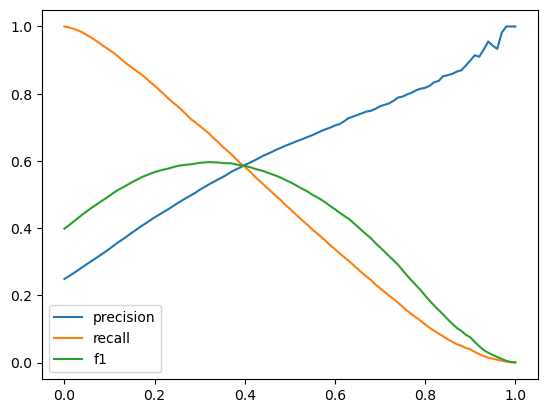

In [16]:
np.count_nonzero(predictions == 1) / len(predictions)

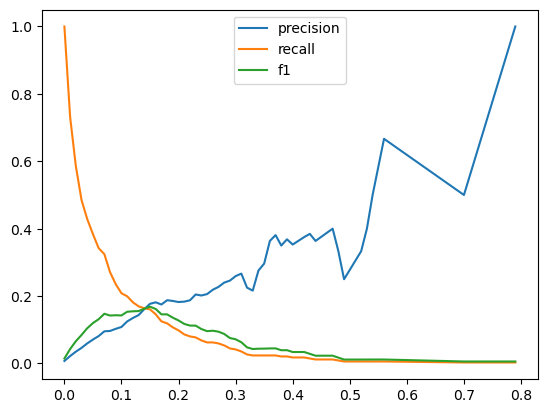

In [11]:
# plot f1 score over chosen threshold
probabilities = clf.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, probabilities)
plt.plot(thresholds, precision[:-1], label="precision")
plt.plot(thresholds, recall[:-1], label="recall")
f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1])
plt.plot(thresholds, f1, label="f1")
plt.legend()
plt.show()

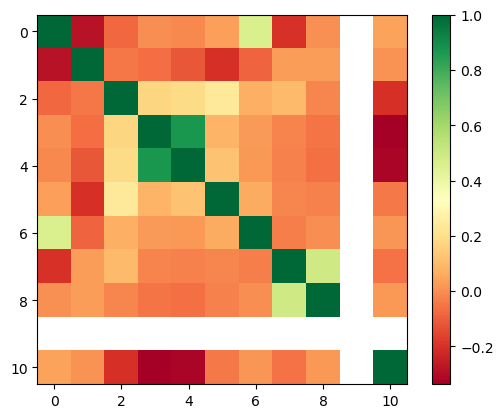

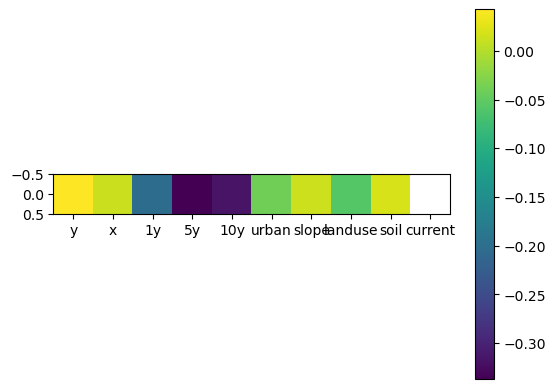

,y,x,1y,5y,10y,urban,slope,landuse,soil,current,target
y,1.000000,-0.279868,-0.078276,0.000358,-0.008600,0.035217,0.461054,-0.199902,0.005375,NaN,0.042471
x,-0.279868,1.000000,-0.047888,-0.065896,-0.116181,-0.202980,-0.088845,0.031467,0.029000,NaN,0.012125
1y,-0.078276,-0.047888,1.000000,0.172726,0.186734,0.234828,0.074747,0.101420,-0.017866,NaN,-0.202607
5y,0.000358,-0.065896,0.172726,1.000000,0.867753,0.085044,0.025225,-0.020285,-0.052985,NaN,-0.336734
10y,-0.008600,-0.116181,0.186734,0.867753,1.000000,0.119289,0.019687,-0.028171,-0.060279,NaN,-0.316029
urban,0.035217,-0.202980,0.234828,0.085044,0.119289,1.000000,0.062590,-0.016243,-0.024954,NaN,-0.040241
slope,0.461054,-0.088845,0.074747,0.025225,0.019687,0.062590,1.000000,-0.031411,0.001022,NaN,0.013835
landuse,-0.199902,0.031467,0.101420,-0.020285,-0.028171,-0.016243,-0.031411,1.000000,0.491580,NaN,-0.058242
soil,0.005375,0.029000,-0.017866,-0.052985,-0.060279,-0.024954,0.001022,0.491580,1.000000,NaN,0.018875
current,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
probabilities

# Data statistics

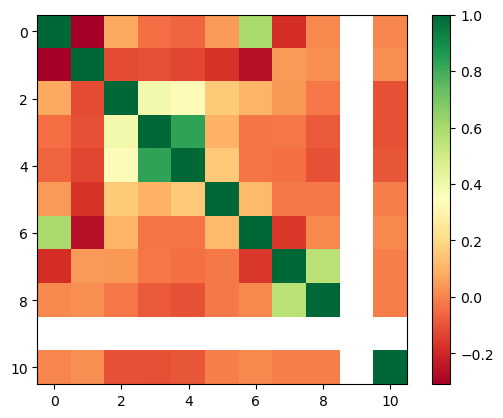

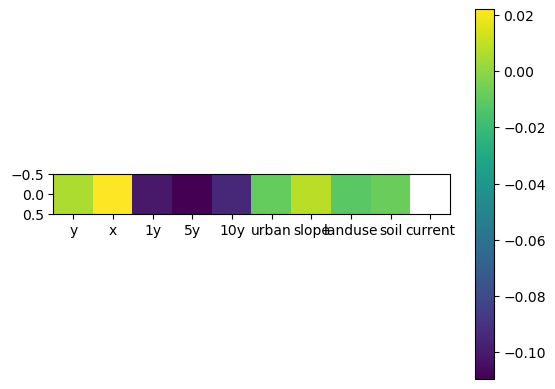

,y,x,1y,5y,10y,urban,slope,landuse,soil,current,target
y,1.000000,-0.310059,0.076204,-0.044332,-0.069425,0.043556,0.598293,-0.184609,0.010820,NaN,0.005583
x,-0.310059,1.000000,-0.115692,-0.105421,-0.127832,-0.167626,-0.261327,0.044074,0.022171,NaN,0.021955
1y,0.076204,-0.115692,1.000000,0.386963,0.334727,0.159035,0.101046,0.039843,-0.027902,NaN,-0.100573
5y,-0.044332,-0.105421,0.386963,1.000000,0.830658,0.096975,-0.029932,-0.026821,-0.087294,NaN,-0.109524
10y,-0.069425,-0.127832,0.334727,0.830658,1.000000,0.153615,-0.032407,-0.041692,-0.106216,NaN,-0.094246
urban,0.043556,-0.167626,0.159035,0.096975,0.153615,1.000000,0.118213,-0.023443,-0.023459,NaN,-0.009365
slope,0.598293,-0.261327,0.101046,-0.029932,-0.032407,0.118213,1.000000,-0.157276,0.008051,NaN,0.008453
landuse,-0.184609,0.044074,0.039843,-0.026821,-0.041692,-0.023443,-0.157276,1.000000,0.556785,NaN,-0.011802
soil,0.010820,0.022171,-0.027902,-0.087294,-0.106216,-0.023459,0.008051,0.556785,1.000000,NaN,-0.008152
current,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# cross correlation matrix
corr = train_features.corr()
plt.imshow(corr, cmap="RdYlGn")
plt.colorbar()
plt.show()
# plot last row
plt.imshow(corr.iloc[-1, :-1].values.reshape(1,10))
plt.xticks(np.arange(10), corr.columns[:-1])
plt.colorbar()
plt.show()
corr

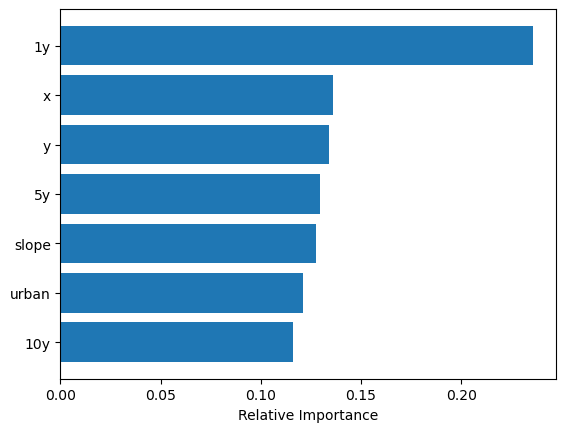

In [20]:
# get feature importance of clf
importances = clf.feature_importances_
# plot feature importance orderd by importance
feature_names = ["y", "x", "1y", "5y", "10y", "urban", "slope"]
feature_names_sorted = feature_names.copy()
indices = np.argsort(importances)
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names_sorted[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()